# Fragility Comparison Analysis

This notebook generates a 2×N grid comparing performance across different fragility levels:
- Top row: Success Rate vs Position Noise
- Bottom row: Break Rate vs Position Noise
- Gold highlight box around the reference fragility level

In [1]:
# ============================================================
# BLOCK 1: IMPORTS & CONSTANTS
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict

# WandB Configuration
ENTITY = "hur"
PROJECT = "SG_Exps"

# Fragility Levels - keys are internal names, each contains method tags
FRAGILITY_LEVELS = {
    #"5N": {
    #    "Pose": "pose_task_frag:2026-01-06_09:18",
    #    "Hybrid-Basic": "basic-hybrid_task_frag:2026-01-06_03:15",
    #    "LCLoP": "LCLoP_task_frag:2026-01-06_02:47",
    #},
    "10N": {
        "Pose": "pose_perf-comp:2026-01-05_10:54",
        "Hybrid-Basic": "basic-hybrid_perf-comp:2026-01-05_10:54",
        "LCLoP": "LCLoP_perf-comp:2026-01-05_10:54",
    },
    "15N": {
        "Pose": "pose_task_frag:2026-01-06_00:52",
        "Hybrid-Basic": "basic-hybrid_task_frag:2026-01-06_00:56",
        "LCLoP": "LCLoP_task_frag:2026-01-06_00:27",
    },
    "20N": {
        "Pose": "pose_task_frag:2026-01-06_00:09",
        "Hybrid-Basic": "basic-hybrid_task_frag:2026-01-06_09:18",
        "LCLoP": "LCLoP_task_frag:2026-01-06_00:09",
    },
    "10000N": {
        "Pose": "pose_task_frag:2026-01-05_23:37",
        "Hybrid-Basic": "basic-hybrid_task_frag:2026-01-06_00:08",
        "LCLoP": "LCLoP_task_frag:2026-01-05_22:12",
    },
}

# Display name mapping (for special cases like 10000N -> Unbreakable)
FRAGILITY_DISPLAY_NAMES = {
    "5N": "$F_{th}$ = 5N",
    "10N": "$F_{th}$ = 10N",
    "15N": "$F_{th}$ = 15N",
    "20N": "$F_{th}$ = 20N",
    "10000N": "Unbreakable",
}

# Highlight box - which fragility level to highlight with gold box
HIGHLIGHT_FRAGILITY = "10N"  # Set to None for no highlight

# Evaluation Tags
TAG_EVAL_PERFORMANCE = "eval_performance"
TAG_EVAL_NOISE = "eval_noise"

# Noise Level Mapping: display label -> metric range string
NOISE_LEVELS = {
    "1mm": "0mm-1mm",
    "2.5mm": "1mm-2.5mm",
    "5mm": "2.5mm-5mm",
    "7.5mm": "5mm-7.5mm",
}

# Metrics
METRIC_SUCCESS = "num_successful_completions"
METRIC_BREAKS = "num_breaks"
METRIC_TOTAL = "total_episodes"

In [2]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

def get_best_checkpoint_per_run(api, method_tag):
    """Find the best checkpoint for each run with the given method tag."""
    runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_PERFORMANCE}]}
    )
    
    best_checkpoints = {}
    for run in runs:
        history = run.history()
        if history.empty:
            print(f"Warning: Run {run.name} has no history data")
            continue
        
        # Calculate score: successes - breaks
        history["score"] = history[f"Eval_Core/{METRIC_SUCCESS}"] - history[f"Eval_Core/{METRIC_BREAKS}"]
        best_idx = history["score"].idxmax()
        best_step = int(history.loc[best_idx, "total_steps"])
        
        best_checkpoints[run.id] = {
            "run_name": run.name,
            "best_step": best_step,
            "score": history.loc[best_idx, "score"],
        }
        print(f"    {run.name}: best checkpoint at step {best_step} (score: {history.loc[best_idx, 'score']:.0f})")
    
    return best_checkpoints

# Get best checkpoints for each fragility level and method
api = wandb.Api()
best_checkpoints = defaultdict(dict)  # best_checkpoints[fragility][method]

for fragility, method_tags in FRAGILITY_LEVELS.items():
    print(f"\n{'='*60}")
    print(f"Fragility: {fragility}")
    print(f"{'='*60}")
    for method_name, method_tag in method_tags.items():
        print(f"\n  {method_name} ({method_tag}):")
        best_checkpoints[fragility][method_name] = get_best_checkpoint_per_run(api, method_tag)

wandb: Currently logged in as: robonuke (hur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Fragility: 10N

  Pose (pose_perf-comp:2026-01-05_10:54):
    Eval_performance_pose_perf-comp_f(10)_0: best checkpoint at step 1228800 (score: 95)
    Eval_performance_pose_perf-comp_f(10)_1: best checkpoint at step 1536000 (score: 97)
    Eval_performance_pose_perf-comp_f(10)_3: best checkpoint at step 1920000 (score: 91)
    Eval_performance_pose_perf-comp_f(10)_4: best checkpoint at step 1113600 (score: 97)
    Eval_performance_pose_perf-comp_f(10)_2: best checkpoint at step 2496000 (score: 96)

  Hybrid-Basic (basic-hybrid_perf-comp:2026-01-05_10:54):
    Eval_performance_basic-hybrid_perf-comp_f(10)_0: best checkpoint at step 1420800 (score: 94)
    Eval_performance_basic-hybrid_perf-comp_f(10)_1: best checkpoint at step 2803200 (score: 97)
    Eval_performance_basic-hybrid_perf-comp_f(10)_2: best checkpoint at step 2227200 (score: 96)
    Eval_performance_basic-hybrid_perf-comp_f(10)_3: best checkpoint at step 2534400 (score: 94)
    Eval_performance_basic-hybrid_perf-comp_f(10)

In [3]:
# ============================================================
# BLOCK 3: DOWNLOAD DATA
# ============================================================

def download_eval_noise_data(api, method_tag, best_checkpoints):
    """Download eval_noise data for best checkpoints across all noise levels."""
    runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_NOISE}]}
    )

    # Build lookup by agent number from best_checkpoints
    checkpoint_by_agent = {}
    for run_id, info in best_checkpoints.items():
        agent_num = info["run_name"].rsplit("_", 1)[-1]
        checkpoint_by_agent[agent_num] = info["best_step"]

    data = []
    for run in runs:
        # Extract agent number from run name
        agent_num = run.name.rsplit("_", 1)[-1]

        if agent_num not in checkpoint_by_agent:
            print(f"Warning: No matching performance run for agent {agent_num} ({run.name})")
            continue

        best_step = checkpoint_by_agent[agent_num]
        history = run.history()
        
        if best_step not in history["total_steps"].values:
            print(f"Warning: Checkpoint {best_step} not found in {run.name}")
            continue
        
        row = history[history["total_steps"] == best_step].iloc[0]
        
        for noise_label, noise_range in NOISE_LEVELS.items():
            prefix = f"Noise_Eval({noise_range})_Core"
            data.append({
                "run_id": run.id,
                "run_name": run.name,
                "checkpoint": best_step,
                "noise_level": noise_label,
                "success": row[f"{prefix}/{METRIC_SUCCESS}"],
                "breaks": row[f"{prefix}/{METRIC_BREAKS}"],
                "total": row[f"{prefix}/{METRIC_TOTAL}"],
            })
    
    return pd.DataFrame(data)

# Download all data
noise_data = defaultdict(dict)  # noise_data[fragility][method]

for fragility, method_tags in FRAGILITY_LEVELS.items():
    print(f"\n{'='*60}")
    print(f"Downloading data for Fragility: {fragility}")
    print(f"{'='*60}")
    for method_name, method_tag in method_tags.items():
        print(f"\n  {method_name}...")
        noise_data[fragility][method_name] = download_eval_noise_data(
            api, method_tag, best_checkpoints[fragility][method_name]
        )

# Print summary
print("\n" + "="*60)
print("DATA SUMMARY")
print("="*60)
for fragility in FRAGILITY_LEVELS.keys():
    print(f"\n{fragility}:")
    for method_name in FRAGILITY_LEVELS[fragility].keys():
        df = noise_data[fragility][method_name]
        if not df.empty:
            num_runs = df["run_name"].nunique()
            print(f"  {method_name}: {num_runs} runs")
        else:
            print(f"  {method_name}: No data")



  Pose...

  Hybrid-Basic...

  LCLoP...


  Pose...

  Hybrid-Basic...

  LCLoP...


  Pose...

  Hybrid-Basic...

  LCLoP...


  Pose...

  Hybrid-Basic...

  LCLoP...

DATA SUMMARY

10N:
  Pose: 5 runs
  Hybrid-Basic: 5 runs
  LCLoP: 5 runs

15N:
  Pose: 5 runs
  Hybrid-Basic: 5 runs
  LCLoP: 5 runs

20N:
  Pose: 5 runs
  Hybrid-Basic: 5 runs
  LCLoP: 5 runs

10000N:
  Pose: 2 runs
  Hybrid-Basic: 5 runs
  LCLoP: 5 runs


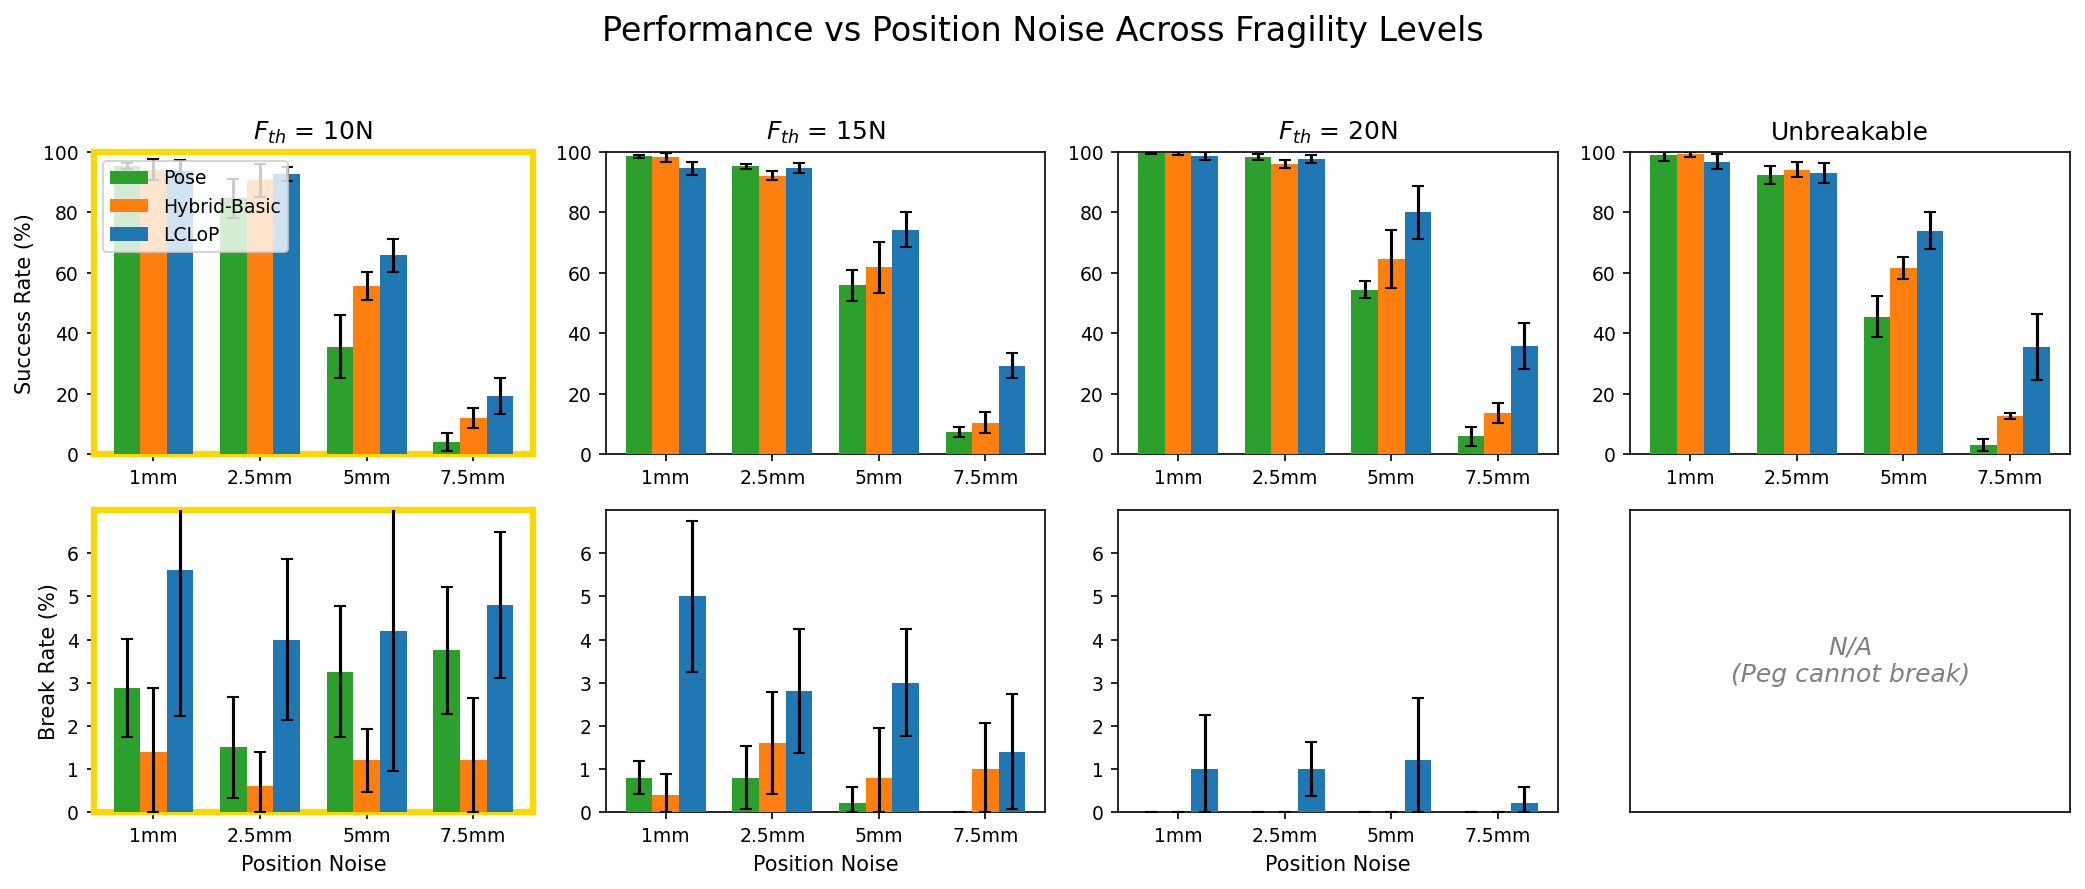

In [4]:
# ============================================================
# BLOCK 4: FRAGILITY COMPARISON FIGURE
# ============================================================

# Policy Selection
TOP_N_POLICIES = None  # Set to integer (e.g., 3) to use top N policies, or None for all

# Highlight Configuration
HIGHLIGHT_FRAGILITY_PLOT = "10N"  # Which fragility to highlight with gold box, or None
HIGHLIGHT_COLOR = "gold"
HIGHLIGHT_LINEWIDTH = 3

# N/A Configuration - for fragility levels where break rate is not applicable
NA_FRAGILITIES = ["10000N"]  # List of fragility keys to show N/A instead of break rate plot
NA_TEXT = "N/A\n(Peg cannot break)"  # Text to display in the N/A box

# Figure Configuration
FIGSIZE = (14, 6)  # Width x Height
DPI = 150
BAR_WIDTH = 0.25

# Colors
COLORS = {
    "Pose": "#2ca02c",        # Green
    "Hybrid-Basic": "#ff7f0e", # Orange
    "LCLoP": "#1f77b4",       # Blue
}

# Font sizes
FONT_SUPTITLE = 16
FONT_TITLE = 12
FONT_AXIS_LABEL = 10
FONT_TICK = 9
FONT_LEGEND = 9
FONT_NA = 12  # Font size for N/A text

# Axis configuration
SUCCESS_Y_LIM = (0, 100)
SUCCESS_Y_TICKS = [0, 20, 40, 60, 80, 100]
BREAK_Y_LIM = (0, 7)
BREAK_Y_TICKS = [i for i in range(BREAK_Y_LIM[1])] #[0, 5, 10, 15, 20, 25]

# Labels
SUPTITLE = "Performance vs Position Noise Across Fragility Levels"
X_LABEL = "Position Noise"
SUCCESS_Y_LABEL = "Success Rate (%)"
BREAK_Y_LABEL = "Break Rate (%)"

# ============================================================

def filter_top_n_runs(df, method_best_checkpoints, top_n):
    """Filter dataframe to only include top N runs by score."""
    if df.empty or top_n is None or len(method_best_checkpoints) <= top_n:
        return df
    sorted_runs = sorted(method_best_checkpoints.items(), key=lambda x: x[1]["score"], reverse=True)
    top_run_names = {info["run_name"] for _, info in sorted_runs[:top_n]}
    # Match by agent number
    top_agent_nums = {name.rsplit("_", 1)[-1] for name in top_run_names}
    return df[df["run_name"].apply(lambda x: x.rsplit("_", 1)[-1] in top_agent_nums)]

def compute_rates_with_ci(df, noise_labels, metric="success"):
    """Compute rates with 95% CI for each noise level. Returns means, lower errors, upper errors."""
    if df.empty:
        zeros = [0] * len(noise_labels)
        return zeros, zeros, zeros
    
    means = []
    errors_lower = []
    errors_upper = []
    
    for noise_label in noise_labels:
        subset = df[df["noise_level"] == noise_label]
        if not subset.empty:
            # Calculate per-seed rates
            subset = subset.copy()
            subset["rate"] = 100 * subset[metric] / subset["total"]
            mean = subset["rate"].mean()
            std = subset["rate"].std()
            n_seeds = len(subset)
            sem = std / np.sqrt(n_seeds)
            ci = 1.96 * sem
            # Clip error bars to [0, 100] range
            errors_lower.append(min(ci, mean - 0))
            errors_upper.append(min(ci, 100 - mean))
            means.append(mean)
        else:
            means.append(0)
            errors_lower.append(0)
            errors_upper.append(0)
    
    return means, errors_lower, errors_upper

# Setup
fragility_keys = list(FRAGILITY_LEVELS.keys())
method_names = list(FRAGILITY_LEVELS[fragility_keys[0]].keys())
noise_labels = list(NOISE_LEVELS.keys())
n_fragilities = len(fragility_keys)
x = np.arange(len(noise_labels))

# Create figure
fig, axes = plt.subplots(2, n_fragilities, figsize=FIGSIZE, dpi=DPI)
fig.suptitle(SUPTITLE, fontsize=FONT_SUPTITLE)

# Plot each fragility level
for col, fragility in enumerate(fragility_keys):
    ax_success = axes[0, col]
    ax_break = axes[1, col]
    
    display_name = FRAGILITY_DISPLAY_NAMES.get(fragility, fragility)
    is_na_fragility = fragility in NA_FRAGILITIES
    
    # Plot bars for each method (success rate)
    for i, method_name in enumerate(method_names):
        df = noise_data[fragility][method_name]
        df = filter_top_n_runs(df, best_checkpoints[fragility][method_name], TOP_N_POLICIES)
        
        success_means, success_err_lo, success_err_hi = compute_rates_with_ci(df, noise_labels, "success")
        offset = (i - len(method_names)/2 + 0.5) * BAR_WIDTH
        
        ax_success.bar(x + offset, success_means, BAR_WIDTH, 
                       label=method_name, color=COLORS[method_name],
                       yerr=[success_err_lo, success_err_hi], capsize=3, zorder=3)
        
        # Only plot break rates if not an N/A fragility
        if not is_na_fragility:
            break_means, break_err_lo, break_err_hi = compute_rates_with_ci(df, noise_labels, "breaks")
            ax_break.bar(x + offset, break_means, BAR_WIDTH,
                         label=method_name, color=COLORS[method_name],
                         yerr=[break_err_lo, break_err_hi], capsize=3, zorder=3)
    
    # Configure success rate subplot
    ax_success.set_title(display_name, fontsize=FONT_TITLE)
    ax_success.set_xticks(x)
    ax_success.set_xticklabels(noise_labels, fontsize=FONT_TICK)
    ax_success.set_ylim(SUCCESS_Y_LIM)
    ax_success.set_yticks(SUCCESS_Y_TICKS)
    ax_success.tick_params(axis='y', labelsize=FONT_TICK)
    
    # Configure break rate subplot
    if is_na_fragility:
        # Clear the axes and show N/A text
        ax_break.set_xticks([])
        ax_break.set_yticks([])
        ax_break.text(0.5, 0.5, NA_TEXT, transform=ax_break.transAxes,
                      fontsize=FONT_NA, ha='center', va='center',
                      style='italic', color='gray')
        # Keep the spines for visual consistency
        for spine in ax_break.spines.values():
            spine.set_visible(True)
    else:
        ax_break.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
        ax_break.set_xticks(x)
        ax_break.set_xticklabels(noise_labels, fontsize=FONT_TICK)
        ax_break.set_ylim(BREAK_Y_LIM)
        ax_break.set_yticks(BREAK_Y_TICKS)
        ax_break.tick_params(axis='y', labelsize=FONT_TICK)
    
    # Only show y-axis label on leftmost plots
    if col == 0:
        ax_success.set_ylabel(SUCCESS_Y_LABEL, fontsize=FONT_AXIS_LABEL)
        ax_break.set_ylabel(BREAK_Y_LABEL, fontsize=FONT_AXIS_LABEL)
    
    # Only show legend on first plot
    if col == 0:
        ax_success.legend(fontsize=FONT_LEGEND, loc='upper left')
    
    # Add gold highlight to spines if this is the highlighted fragility
    if HIGHLIGHT_FRAGILITY_PLOT is not None and fragility == HIGHLIGHT_FRAGILITY_PLOT:
        for spine in ['top', 'left', 'right', 'bottom']:
            ax_success.spines[spine].set_color(HIGHLIGHT_COLOR)
            ax_success.spines[spine].set_linewidth(HIGHLIGHT_LINEWIDTH)
            ax_break.spines[spine].set_color(HIGHLIGHT_COLOR)
            ax_break.spines[spine].set_linewidth(HIGHLIGHT_LINEWIDTH)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave room for suptitle
plt.show()